<a href="https://colab.research.google.com/github/kavizahan12/FindingPoliceStations/blob/master/recsys_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
import tensorflow as tf
from datetime import datetime

In [ ]:
def convertCategory(x):#converts the category x into 13 if x="S" else it won't convert.
    if x=="S":
        return 13
    return x


In [ ]:
def convertTime(x):#converts the date and time into string and calculates total time in second from 1st Jan,1970 to x.
    time=datetime.strptime(x,"%Y-%m-%dT%H:%M:%S.%fZ")
    epoch=datetime(1970,1,1)
    return (time-epoch).total_seconds()

In [ ]:
clicks_header=["session","time","item","category"]#header array for clicks datasets.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')#retrieving the datasets from Google Drive.

Mounted at /content/drive


In [ ]:
clicks=pd.read_csv("/content/drive/MyDrive/yoochoose-data/yoochoose-clicks.dat",nrows=100000,dtype=float,names=clicks_header,converters={"category":convertCategory,"time":convertTime})
#creates a csv file of clicks dataset with 100000 rows,names of the click_header array, float data type and converts the categories and times using the functions given above.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Both a converter and dtype were specified for column time - only the converter will be used
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Both a converter and dtype were specified for column category - only the converter will be used
  """Entry point for launching an IPython kernel.


In [ ]:
sessionFreq=clicks["session"].value_counts()#creates another column for the number of clicks occur during the specified sessions.

In [ ]:
clicks["sessionFreq"]=clicks["session"].map(lambda x:sessionFreq[x])#adding the column sessionFrequency into clicks datasets.

In [ ]:
clicks.fillna(0,inplace=True)#All NA are filled with 0s.
values=clicks.values#collecting the values and store them into values array.
values=values.astype('float32')#convert the values into floattype values.
clicks# display the clicks datasets.

,session,time,item,category,sessionFreq
0,1.0,1.396868e+09,214536502.0,0,4
1,1.0,1.396868e+09,214536500.0,0,4
2,1.0,1.396868e+09,214536506.0,0,4
3,1.0,1.396868e+09,214577561.0,0,4
4,2.0,1.396879e+09,214662742.0,0,6
...,...,...,...,...,...
99995,31812.0,1.396372e+09,214662819.0,0,5
99996,31812.0,1.396372e+09,214836765.0,0,5
99997,31812.0,1.396372e+09,214836073.0,0,5
99998,31812.0,1.396372e+09,214662819.0,0,5


In [ ]:
scaler=MinMaxScaler(feature_range=(0,1))#normalizing the values using MinMaxScaler function.
scaled=scaler.fit_transform(values)
scaled=pd.DataFrame(scaled)
scaled#displaying the clicks datasets with normalized values.

,0,1,2,3,4
0,0.000000,0.904541,0.000068,0.0,0.031915
1,0.000000,0.905029,0.000068,0.0,0.031915
2,0.000000,0.905029,0.000068,0.0,0.031915
3,0.000000,0.905273,0.000164,0.0,0.031915
4,0.000031,0.923096,0.000363,0.0,0.053191
...,...,...,...,...,...
99995,0.970854,0.084473,0.000363,0.0,0.042553
99996,0.970854,0.084717,0.000769,0.0,0.042553
99997,0.970854,0.084717,0.000767,0.0,0.042553
99998,0.970854,0.084717,0.000363,0.0,0.042553


In [ ]:
def create_ts_data(dataset,lookback=1,predicted_col=1):#Creates Test Datasets.
  temp=dataset.copy()#copying the clicks datasets into temp for training.
  temp["id"]=range(1,len(temp)+1)#serial numbers.
  temp=temp.iloc[:-lookback,:]#it slices the temp datasets
  temp.set_index('id',inplace=True)# it adds the serial numbers in datasets.
  predicted_value=dataset.copy()##copying the clicks datasets into predicted_value for testing.
  predicted_value=predicted_value.iloc[lookback:,predicted_col]#the predicted values have rows without 1st row and only 1 column.
  predicted_value.columns=["Predicted"]#new header name for new column
  predicted_value=pd.DataFrame(predicted_value)#adding new column in predicted datasets.
  predicted_value["id"]=range(1,len(predicted_value)+1)#generating serial numbers.
  predicted_value.set_index('id',inplace=True)#adding serial numbers into datasets.
  final_df=pd.concat([temp,predicted_value],axis=1)#concatinating training and testing datasets into one and make it two dimensionals.
  return final_df

In [ ]:
reframed_df=create_ts_data(scaled,1,0)#making datasets into three dimensionals.
reframed_df.fillna(0,inplace=True)#make NA as 0s.
reframed_df.columns=['var1(t-1)','var2(t-1)','var3(t-1)','var4(t-1)','var5(t-1)','var1(t)']#naming the columns of the datasets.
print(reframed_df)

       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)
id                                                                    
1       0.000000   0.904541   0.000068        0.0   0.031915  0.000000
2       0.000000   0.905029   0.000068        0.0   0.031915  0.000000
3       0.000000   0.905029   0.000068        0.0   0.031915  0.000000
4       0.000000   0.905273   0.000164        0.0   0.031915  0.000031
5       0.000031   0.923096   0.000363        0.0   0.053191  0.000031
...          ...        ...        ...        ...        ...       ...
99995   0.970884   0.752441   0.000429        0.0   0.010638  0.970854
99996   0.970854   0.084473   0.000363        0.0   0.042553  0.970854
99997   0.970854   0.084717   0.000769        0.0   0.042553  0.970854
99998   0.970854   0.084717   0.000767        0.0   0.042553  0.970854
99999   0.970854   0.084717   0.000363        0.0   0.042553  0.970854

[99999 rows x 6 columns]


In [ ]:
values=reframed_df.values#collecting the values.
train_X,train_y=values[:,:-1],values[:,-1]#spliting the datasets into features and class label.

In [ ]:
test_clicks=pd.read_csv("/content/drive/MyDrive/yoochoose-data/yoochoose-test.dat",dtype=float,nrows=100000,names=clicks_header,converters={"category":convertCategory,"time":convertTime})# importing the test_clicks datasets.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Both a converter and dtype were specified for column time - only the converter will be used
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Both a converter and dtype were specified for column category - only the converter will be used
  """Entry point for launching an IPython kernel.


In [ ]:
sessionFreq=test_clicks["session"].value_counts()

In [ ]:
test_clicks["sessionFreq"]=test_clicks["session"].map(lambda x:sessionFreq[x])

In [ ]:
test_clicks.fillna(0,inplace=True)
values_1=test_clicks.values
values_1=values_1.astype('float32')
test_clicks

,session,time,item,category,sessionFreq
0,5.0,1.396891e+09,214530776.0,0,3
1,5.0,1.396891e+09,214530776.0,0,3
2,5.0,1.396891e+09,214530776.0,0,3
3,10.0,1.396597e+09,214820942.0,0,2
4,10.0,1.396598e+09,214826810.0,0,2
...,...,...,...,...,...
99995,126875.0,1.396509e+09,214839373.0,0,2
99996,126865.0,1.396878e+09,214835912.0,0,2
99997,126865.0,1.396878e+09,214835912.0,0,2
99998,126870.0,1.396900e+09,214554714.0,0,1


In [ ]:
scaler_1=MinMaxScaler(feature_range=(0,1))
scaled_1=scaler_1.fit_transform(values_1)
scaled_1=pd.DataFrame(scaled_1)
scaled_1

,0,1,2,3,4
0,0.000000,0.941895,0.000055,0.0,0.019048
1,0.000000,0.942627,0.000055,0.0,0.019048
2,0.000000,0.942627,0.000055,0.0,0.019048
3,0.000038,0.456787,0.000732,0.0,0.009524
4,0.000038,0.456787,0.000745,0.0,0.009524
...,...,...,...,...,...
99995,0.967993,0.310547,0.000775,0.0,0.009524
99996,0.967917,0.920166,0.000767,0.0,0.009524
99997,0.967917,0.920410,0.000767,0.0,0.009524
99998,0.967955,0.957520,0.000111,0.0,0.000000


In [ ]:
reframed_df_1=create_ts_data(scaled_1,1,0)
reframed_df_1.fillna(0,inplace=True)
reframed_df_1.columns=['var1(t-1)','var2(t-1)','var3(t-1)','var4(t-1)','var5(t-1)','var1(t)']
print(reframed_df_1.head(4))

    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)
id                                                                 
1    0.000000   0.941895   0.000055        0.0   0.019048  0.000000
2    0.000000   0.942627   0.000055        0.0   0.019048  0.000000
3    0.000000   0.942627   0.000055        0.0   0.019048  0.000038
4    0.000038   0.456787   0.000732        0.0   0.009524  0.000038


In [ ]:

values_1=reframed_df_1.values


In [ ]:



test_X,test_y=values_1[:,:-1],values_1[:,-1]

In [ ]:
train_X=train_X.reshape((train_X.shape[0],1,train_X.shape[1]))
test_X=test_X.reshape((test_X.shape[0],1,test_X.shape[1]))
print(train_X.shape,train_y.shape,test_X.shape,test_y.shape)

(99999, 1, 5) (99999,) (99999, 1, 5) (99999,)


In [ ]:
import keras.backend as K
def recall(y_true,y_pred):
    true_positives=K.sum(K.round(K.clip(y_true*y_pred,0,1)))
    #possible_positives=K.sum(K.round(K.clip(y_true,0,1)))
    #recall=true_positives/(true_positives+K.epsilon())
    recall=true_positives/20
    return recall

In [ ]:
def mrr(y_true,y_pred):
    mrr=K.mean(1/y_pred)
    return K.abs(mrr)

In [ ]:
from keras.layers import*

model_gru=Sequential()
model_gru.add(GRU(512,dropout=0.87,input_shape=(train_X.shape[1],train_X.shape[2]),return_sequences=True))

model_gru.add(GRU(units=256,dropout=0.87,return_sequences=True))
model_gru.add(GRU(units=256,dropout=0.87,return_sequences=True))
model_gru.add(GRU(units=256,dropout=0.87,return_sequences=True))
model_gru.add(GRU(units=128,dropout=0.87,return_sequences=True))
model_gru.add(GRU(units=64,return_sequences=True))
model_gru.add(GRU(units=64,return_sequences=True))
model_gru.add(GRU(units=32,return_sequences=True))




model_gru.add(GRU(units=32))


model_gru.add(Dense(units=1))


model_gru.compile(loss='hinge',optimizer='adam',metrics=[recall,mrr])
model_gru.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_36 (GRU)                 (None, 1, 512)            797184    
_________________________________________________________________
gru_37 (GRU)                 (None, 1, 256)            591360    
_________________________________________________________________
gru_38 (GRU)                 (None, 1, 256)            394752    
_________________________________________________________________
gru_39 (GRU)                 (None, 1, 256)            394752    
_________________________________________________________________
gru_40 (GRU)                 (None, 1, 128)            148224    
_________________________________________________________________
gru_41 (GRU)                 (None, 1, 64)             37248     
_________________________________________________________________
gru_42 (GRU)                 (None, 1, 64)            

In [ ]:
gru_history=model_gru.fit(train_X,train_y,epochs=10,batch_size=256,validation_data=(test_X,test_y),shuffle=False)

Epoch 1/10
391/391 [==============================] - 76s 157ms/step - loss: 0.3434 - recall: 8.3651 - mrr: inf - val_loss: 0.0619 - val_recall: 11.9981 - val_mrr: 0.1246
Epoch 2/10
391/391 [==============================] - 60s 153ms/step - loss: 0.2079 - recall: 9.8872 - mrr: 0.0979 - val_loss: 0.0437 - val_recall: 12.2336 - val_mrr: 0.0879
Epoch 3/10
391/391 [==============================] - 59s 150ms/step - loss: 0.1697 - recall: 10.4664 - mrr: 0.0764 - val_loss: 0.0358 - val_recall: 12.3331 - val_mrr: 0.0724
Epoch 4/10
391/391 [==============================] - 59s 151ms/step - loss: 0.1487 - recall: 10.7819 - mrr: 0.0653 - val_loss: 0.0310 - val_recall: 12.3876 - val_mrr: 0.0630
Epoch 5/10
391/391 [==============================] - 59s 151ms/step - loss: 0.1345 - recall: 10.9895 - mrr: 0.0580 - val_loss: 0.0278 - val_recall: 12.4347 - val_mrr: 0.0565
Epoch 6/10
391/391 [==============================] - 60s 152ms/step - loss: 0.1239 - recall: 11.1337 - mrr: 0.0525 - val_loss: 0.

In [ ]:
from keras.layers import*

model_gru2=Sequential()

model_gru2.add(GRU(512,dropout=0.87,input_shape=(train_X.shape[1],train_X.shape[2]),return_sequences=True))

model_gru2.add(GRU(units=256,dropout=0.87,return_sequences=True))
model_gru2.add(GRU(units=256,dropout=0.87,return_sequences=True))
model_gru2.add(GRU(units=256,dropout=0.87,return_sequences=True))
model_gru2.add(GRU(units=128,dropout=0.87,return_sequences=True))
model_gru2.add(GRU(units=64,return_sequences=True))
model_gru2.add(GRU(units=64,return_sequences=True))
model_gru2.add(GRU(units=32,return_sequences=True))




model_gru2.add(GRU(units=32))


model_gru2.add(Dense(units=1,activation='softmax'))


model_gru2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=[recall,mrr])
model_gru2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_54 (GRU)                 (None, 1, 512)            797184    
_________________________________________________________________
gru_55 (GRU)                 (None, 1, 256)            591360    
_________________________________________________________________
gru_56 (GRU)                 (None, 1, 256)            394752    
_________________________________________________________________
gru_57 (GRU)                 (None, 1, 256)            394752    
_________________________________________________________________
gru_58 (GRU)                 (None, 1, 128)            148224    
_________________________________________________________________
gru_59 (GRU)                 (None, 1, 64)             37248     
_________________________________________________________________
gru_60 (GRU)                 (None, 1, 64)            

In [ ]:
gru_history2=model_gru2.fit(train_X,train_y,epochs=10,batch_size=256,validation_data=(test_X,test_y),shuffle=False)

Epoch 1/10
391/391 [==============================] - 76s 155ms/step - loss: 0.0000e+00 - recall: 1.8061 - mrr: 1.0000 - val_loss: 0.0000e+00 - val_recall: 6.2370 - val_mrr: 1.0000
Epoch 2/10
391/391 [==============================] - 58s 149ms/step - loss: 0.0000e+00 - recall: 1.8061 - mrr: 1.0000 - val_loss: 0.0000e+00 - val_recall: 6.2370 - val_mrr: 1.0000
Epoch 3/10
391/391 [==============================] - 58s 148ms/step - loss: 0.0000e+00 - recall: 1.8061 - mrr: 1.0000 - val_loss: 0.0000e+00 - val_recall: 6.2370 - val_mrr: 1.0000
Epoch 4/10
391/391 [==============================] - 58s 148ms/step - loss: 0.0000e+00 - recall: 1.8061 - mrr: 1.0000 - val_loss: 0.0000e+00 - val_recall: 6.2370 - val_mrr: 1.0000
Epoch 5/10
391/391 [==============================] - 58s 148ms/step - loss: 0.0000e+00 - recall: 1.8061 - mrr: 1.0000 - val_loss: 0.0000e+00 - val_recall: 6.2370 - val_mrr: 1.0000
Epoch 6/10
391/391 [==============================] - 58s 148ms/step - loss: 0.0000e+00 - recal

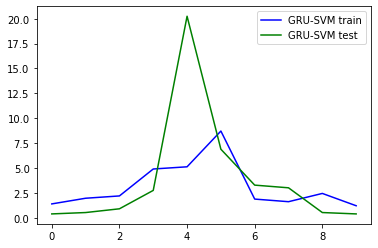

In [ ]:
  pyplot.plot(gru_history.history['mrr'],label='GRU-SVM train',color='blue')
  pyplot.plot(gru_history.history['val_mrr'],label='GRU-SVM test',color='green')
 
  pyplot.legend()
  pyplot.show()                                                                 

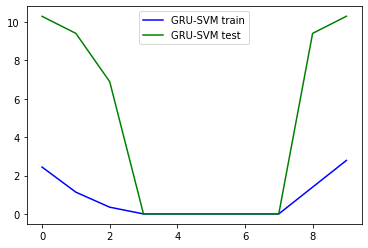

In [ ]:
pyplot.plot(gru_history.history['recall'],label='GRU-SVM train',color='blue')
pyplot.plot(gru_history.history['val_recall'],label='GRU-SVM test',color='green')
 
pyplot.legend()
pyplot.show()  

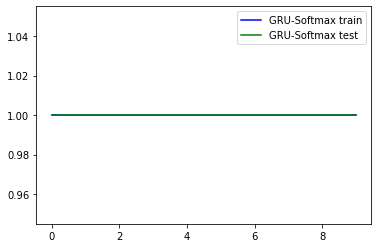

In [ ]:
pyplot.plot(gru_history2.history['mrr'],label='GRU-Softmax train',color='blue')
pyplot.plot(gru_history2.history['val_mrr'],label='GRU-Softmax test',color='green')
 
pyplot.legend()
pyplot.show()                                                                 

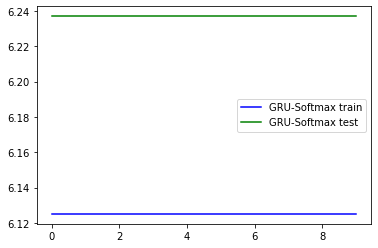

In [ ]:
pyplot.plot(gru_history2.history['recall'],label='GRU-Softmax train',color='blue')
pyplot.plot(gru_history2.history['val_recall'],label='GRU-Softmax test',color='green')
 
pyplot.legend()
pyplot.show()  

In [ ]:
from keras.layers import*

model_gru3=Sequential()

model_gru3.add(GRU(512,dropout=0.87,input_shape=(train_X.shape[1],train_X.shape[2]),return_sequences=True))

model_gru3.add(GRU(units=256,dropout=0.87,return_sequences=True))
model_gru3.add(GRU(units=256,dropout=0.87,return_sequences=True))
model_gru3.add(GRU(units=256,dropout=0.87,return_sequences=True))
model_gru3.add(GRU(units=128,dropout=0.87,return_sequences=True))
model_gru3.add(GRU(units=64,return_sequences=True))
model_gru3.add(GRU(units=64,return_sequences=True))
model_gru3.add(GRU(units=32,return_sequences=True))




model_gru3.add(GRU(units=32))


model_gru3.add(Dense(units=1,activation='softmax'))


model_gru3.compile(loss='cosine_similarity',optimizer='sgd',metrics=[recall,mrr])
model_gru3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_63 (GRU)                 (None, 1, 512)            797184    
_________________________________________________________________
gru_64 (GRU)                 (None, 1, 256)            591360    
_________________________________________________________________
gru_65 (GRU)                 (None, 1, 256)            394752    
_________________________________________________________________
gru_66 (GRU)                 (None, 1, 256)            394752    
_________________________________________________________________
gru_67 (GRU)                 (None, 1, 128)            148224    
_________________________________________________________________
gru_68 (GRU)                 (None, 1, 64)             37248     
_________________________________________________________________
gru_69 (GRU)                 (None, 1, 64)            

In [ ]:
gru_history3=model_gru3.fit(train_X,train_y,epochs=10,batch_size=256,validation_data=(test_X,test_y),shuffle=False)

Epoch 1/10
391/391 [==============================] - 75s 154ms/step - loss: -0.9998 - recall: 1.8061 - mrr: 1.0000 - val_loss: -1.0000 - val_recall: 6.2370 - val_mrr: 1.0000
Epoch 2/10
391/391 [==============================] - 57s 147ms/step - loss: -0.9998 - recall: 1.8061 - mrr: 1.0000 - val_loss: -1.0000 - val_recall: 6.2370 - val_mrr: 1.0000
Epoch 3/10
391/391 [==============================] - 57s 147ms/step - loss: -0.9998 - recall: 1.8061 - mrr: 1.0000 - val_loss: -1.0000 - val_recall: 6.2370 - val_mrr: 1.0000
Epoch 4/10
391/391 [==============================] - 58s 148ms/step - loss: -0.9998 - recall: 1.8061 - mrr: 1.0000 - val_loss: -1.0000 - val_recall: 6.2370 - val_mrr: 1.0000
Epoch 5/10
391/391 [==============================] - 58s 147ms/step - loss: -0.9998 - recall: 1.8061 - mrr: 1.0000 - val_loss: -1.0000 - val_recall: 6.2370 - val_mrr: 1.0000
Epoch 6/10
391/391 [==============================] - 58s 148ms/step - loss: -0.9998 - recall: 1.8061 - mrr: 1.0000 - val_los

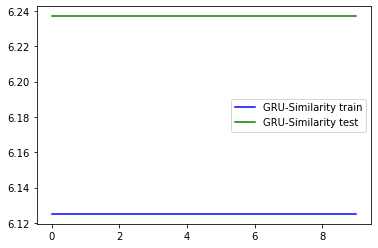

In [ ]:
pyplot.plot(gru_history3.history['recall'],label='GRU-Similarity train',color='blue')
pyplot.plot(gru_history3.history['val_recall'],label='GRU-Similarity test',color='green')
 
pyplot.legend()
pyplot.show() 